## PyTorch Datasets and DataLoaders

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

In [5]:
!pip install torch torchvision
import torch
import torchvision
import torchvision.transforms as transforms

# Define data transformations for training data
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # 随机水平翻转图像
    transforms.RandomCrop(32, padding=4),  # 随机裁剪图像，并在周围填充0
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Define data transformations for test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Load the CIFAR10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

# Create DataLoaders for train and test datasets
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=2
)

print("Num training examples: {}".format(len(train_dataset)))
print("Num test examples: {}".format(len(test_dataset)))


# List of class labels
classes = [
    'plane', 'car', 'bird', 'cat',
    'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]

Files already downloaded and verified
Files already downloaded and verified
Num training examples: 50000
Num test examples: 10000


## Visualizing Examples from the CIFAR10 Dataset

Note: you may need to restart the kernel to use updated packages.


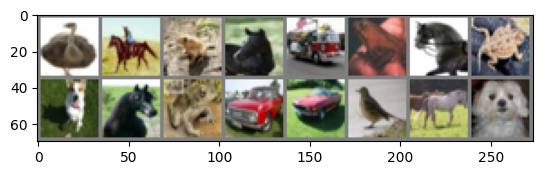

bird -- horse -- frog -- horse -- truck -- frog -- horse -- frog
dog -- horse -- frog -- car -- car -- bird -- horse -- dog


In [7]:
%pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display the images in a grid along with their labels
imshow(torchvision.utils.make_grid(images[:16]))
print(" -- ".join(f"{classes[labels[j]]}" for j in range(8)))
print(" -- ".join(f"{classes[labels[j]]}" for j in range(8,16)))

## Training on the GPU and Evaluating Performance

### Calculate train loss and test loss

In [11]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define the neural network
class TwoLayerNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(TwoLayerNet, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

        # Initialize weights of self.linear with a small random number from a normal distribution
        #nn.init.normal_(self.linear1.weight, mean=0.0, std=0.01)
        #nn.init.normal_(self.linear2.weight, mean=0.0, std=0.01)
        nn.init.kaiming_uniform_(self.linear1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.linear2.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = x.view(-1, 3*32*32)  # 將x展平以匹配全連接層的期望輸入形狀
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Adjusting the input layer to match CIFAR10 size
D_in, H, D_out = 3*32*32, 1000, 10  # CIFAR10: 3 color channels, 32x32 pixels

# Create an instance of the neural network
net = TwoLayerNet(D_in, H, D_out)
print(net)

# Move the model to the GPU if available
net.to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001) #weight_decay=L2λ 添加一个与权重大小相关的L2项来抑制过拟合，影响梯度更新。

# Train the neural network
num_epochs = 5
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

for epoch in range(num_epochs):
    # Set the model to training mode
    net.train()  
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0): #每個epoch内，模型處理782個mini-batch=64張圖，共50000張圖。
        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update the running loss
        running_loss += loss.item()

    # 更新学习率
    scheduler.step()

    # 訓練損失: 782個mini-batch loss的平均值
    avg_train_loss = running_loss / (i + 1)
    #print(f"Epoch [{epoch + 1}/{num_epochs}], trainLoss: {avg_train_loss:.4f}")
#print("Training finished.")


    # Set the model to evaluation mode
    net.eval()
    # Test the neural network
    correct = 0
    total = 0
    test_loss = 0.0

    # Disable gradient calculation
    with torch.no_grad():
        for inputs, labels in test_loader:
            #print(inputs.size(), labels.size())

            # Move the inputs and labels to the GPU if available
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = net(inputs)

            # Calculate test loss
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)  # 将损失累加，考虑到每个批次的大小
            
            # Get the predicted class
            _, predicted = torch.max(outputs.data, 1)

            # Update the total number of samples and correct predictions
            total += labels.size(0)
    
            correct += (predicted == labels).sum().item()

    # 计算平均测试损失
    avg_test_loss = test_loss / len(test_loader.dataset)
    # Calculate the accuracy
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%")

Using device: cpu
TwoLayerNet(
  (linear1): Linear(in_features=3072, out_features=1000, bias=True)
  (linear2): Linear(in_features=1000, out_features=10, bias=True)
)
Epoch [1/5], Train Loss: 1.8546, Test Loss: 1.6237, Accuracy: 43.78%
Epoch [2/5], Train Loss: 1.5050, Test Loss: 1.5321, Accuracy: 46.31%
Epoch [3/5], Train Loss: 1.4118, Test Loss: 1.4606, Accuracy: 48.99%
Epoch [4/5], Train Loss: 1.2922, Test Loss: 1.3925, Accuracy: 51.64%
Epoch [5/5], Train Loss: 1.1751, Test Loss: 1.3040, Accuracy: 54.75%
